In [1]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)
tf.enable_eager_execution(config=tf.ConfigProto(gpu_options=gpu_options))

In [2]:
import time
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import clear_output
from shared import make_dataset, random_jitter, Generator, Discriminator, normalize, \
train_step, generate_images, generate_plot

In [3]:
%matplotlib inline

In [4]:
PATH = Path("/scratch/datasets/astro_deconv_2019/")
CHECKPOINT_PREFIX = Path('training_checkpoints/gan')
BUFFER_SIZE = 200
BATCH_SIZE = 1
IMG_SIZE = 256
OUTPUT_CHANNELS = 1
LAMBDA = 100
EPOCHS = 5
LR = 0.001
TEST_INTERVAL = 100
CHECKPOINT_INTERVAL = 5000

In [5]:
train_dirty_dataset = make_dataset(PATH / 'train/*-dirty.fits')
train_skymodel_dataset = make_dataset(PATH / 'train/*-skymodel.fits')
train_psf_dataset = make_dataset(PATH / 'train/*-psf.fits')
train_clean_beam_dataset = make_dataset(PATH / 'train/*-clean-beam.fits')
train_dataset = tf.data.Dataset.zip((train_dirty_dataset, train_skymodel_dataset, train_psf_dataset, train_clean_beam_dataset))
train_dataset = train_dataset.map(random_jitter)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

test_dirty_dataset = make_dataset(PATH / 'test/*-dirty.fits')
test_wsclean_dataset = make_dataset(PATH / 'test/*-wsclean-model.fits')
test_skymodel_dataset = make_dataset(PATH / 'test/*-skymodel.fits')
test_psf_dataset = make_dataset(PATH / 'test/*-psf.fits')
test_clean_beam_dataset = make_dataset(PATH / 'test/*-clean-beam.fits')

test_dataset = tf.data.Dataset.zip((test_dirty_dataset, test_skymodel_dataset, test_psf_dataset, test_clean_beam_dataset, test_wsclean_dataset))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(1)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.


In [6]:
generator = Generator(IMG_SIZE=IMG_SIZE, OUTPUT_CHANNELS=OUTPUT_CHANNELS)
discriminator = Discriminator()
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.train.AdamOptimizer(learning_rate=LR, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=LR, beta1=0.5)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Train the shit

l1_loss: 0.0415 gan_loss: 2.5206


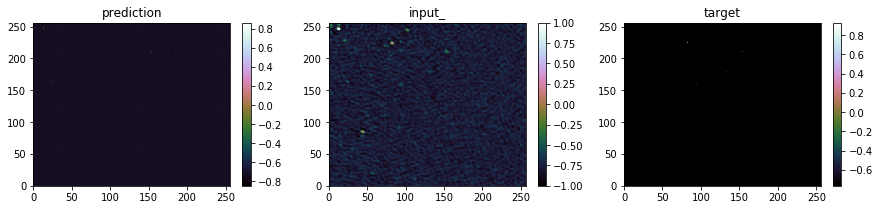

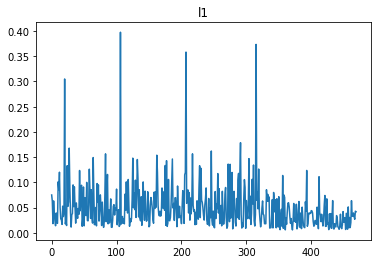

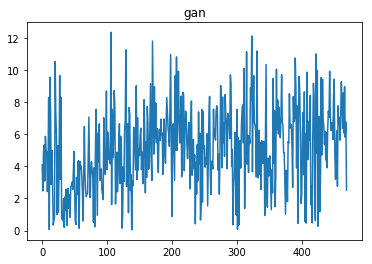

step: 9400 epoch: 5 duration: 5687.89s step/s: 1.65

.

In [8]:
l1s = []
gans = []

for epoch in range(EPOCHS):
    step = 0
    start = time.time()

    for input_, target, psf, clean_beam in train_dataset:
        min_, max_, input_, target, = normalize(input_, target)
        train_step(loss_object, generator, generator_optimizer,
                   discriminator_optimizer, discriminator, input_, target, LAMBDA)
        step += 1
        print(".", end = '')

        if (step + 1) % TEST_INTERVAL == 0:
            clear_output(wait=True)
            for test_input, test_target, test_psf, test_cleanbeam, test_wsclean in test_dataset.take(1):
                r = normalize(test_input, test_target, test_wsclean)
                min_, max_, test_input, test_target, wsclean = r
                test_prediction = generator(test_input, training=True)
                disc_real_output = discriminator([test_input, test_target], training=True)
                disc_generated_output = discriminator([test_input, test_prediction], training=True)
                gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
                l1_loss = tf.reduce_mean(tf.abs(test_target - test_prediction))
                print(f"l1_loss: {l1_loss:.4f} gan_loss: {gan_loss:.4f}")
                l1s.append(l1_loss)
                gans.append(gan_loss)
                generate_images(test_prediction, test_input, test_target)
                generate_plot([i.numpy() for i in l1s], 'l1')
                generate_plot([i.numpy() for i in gans], 'gan')
                

                duration = time.time()-start
                speed = step / duration
                print(f"step: {step + 1} epoch: {epoch + 1} duration: {duration:.2f}s step/s: {speed:.2f}\n")

        if (step + 1) % CHECKPOINT_INTERVAL == 0:
            checkpoint.save(file_prefix=str(CHECKPOINT_PREFIX))